# Wi-Fi Network Security Threat Detection Using Machine Learning

In [1]:
dataset_directory = "../datasets/wifi"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from datetime import datetime
import os
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, precision_recall_curve,
                           average_precision_score, confusion_matrix,
                           roc_curve, auc, silhouette_score)
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

# For reproducibility
np.random.seed(42)


## 1. Load CSV Files

In [3]:
normal_df = pd.read_csv(f"{dataset_directory}/normal_output.csv", low_memory=False)
anomaly_df = pd.read_csv(f"{dataset_directory}/anomaly_filtered.csv", low_memory=False)

In [4]:
# Brief look at the data
print(normal_df.head())
print(anomaly_df.head())

# Check shape of the data
print(normal_df.shape)
print(anomaly_df.shape)

# Output column names
print(normal_df.columns)
print(anomaly_df.columns)

   frame.time_epoch  frame.time_relative  frame.len  frame.cap_len  \
0      1.729577e+09             0.000000       1363           1363   
1      1.729577e+09             0.018642         66             66   
2      1.729577e+09             0.111891         54             54   
3      1.729577e+09             0.139637         42             42   
4      1.729577e+09             0.347460         83             83   

   frame.marked              frame.protocols            eth.src  \
0         False  eth:ethertype:ipv6:udp:mdns  02:94:9e:b4:f2:de   
1         False         eth:ethertype:ip:tcp  d8:3a:dd:c1:e5:e4   
2         False         eth:ethertype:ip:tcp  d8:3a:dd:c1:e5:e4   
3         False            eth:ethertype:arp  02:94:9e:b4:f2:de   
4         False    eth:ethertype:ip:udp:data  02:94:9e:b4:f2:de   

             eth.dst eth.type ip.version  ... udp.srcport udp.dstport  \
0  33:33:00:00:00:fb   0x86dd          6  ...      5353.0      5353.0   
1  02:94:9e:b4:f2:de   0x0800 

In [5]:
# Label normal data as 0 and anomaly data as 1
normal_df['label'] = 0
anomaly_df['label'] = 1

### Merge DF

In [6]:
df = pd.concat([normal_df, anomaly_df], axis=0)

df = df.sort_values(by='frame.time_epoch').reset_index(drop=True)

In [7]:
print(df.shape)

print(df.isna().sum())

(11466018, 42)
frame.time_epoch              0
frame.time_relative           0
frame.len                     0
frame.cap_len                 0
frame.marked                  0
frame.protocols               0
eth.src                       0
eth.dst                       0
eth.type                      0
ip.version                 3058
ip.src                   269638
ip.dst                   269638
ip.len                   269638
ip.ttl                   269638
ip.proto                 269638
ip.flags.mf              269638
ip.flags.df              269638
ip.frag_offset           269638
ip.checksum              269638
tcp.srcport             1854821
tcp.dstport             1854821
tcp.flags               1854821
tcp.flags.syn           1854821
tcp.flags.ack           1854821
tcp.flags.fin           1854821
tcp.len                 1855347
tcp.stream              1854821
tcp.seq                 1854821
tcp.ack                 1854821
tcp.window_size         1854821
tcp.checksum            1

In [8]:
# Drop columns that redundant or not useful
columns_to_drop = [
    'frame.time_relative',
    'frame.cap_len',
    'frame.marked',
    'ip.version',
    'ip.checksum',
    'ip.frag_offset',
    'tcp.flags',
    'tcp.len',
    'tcp.seq',
    'tcp.ack',
    'tcp.checksum',
    'tcp.window_size',
    'udp.checksum',
    'eth.type',
    'http.request.method',
    'http.request.uri',
    'http.response.code',
    'dns.qry.name',
    'dns.resp.name',
    '_ws.col.protocol'
]
df = df.drop(columns=columns_to_drop)

print(df.shape)

(11466018, 22)


In [9]:
print(df.columns)

Index(['frame.time_epoch', 'frame.len', 'frame.protocols', 'eth.src',
       'eth.dst', 'ip.src', 'ip.dst', 'ip.len', 'ip.ttl', 'ip.proto',
       'ip.flags.mf', 'ip.flags.df', 'tcp.srcport', 'tcp.dstport',
       'tcp.flags.syn', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.stream',
       'udp.srcport', 'udp.dstport', 'udp.length', 'label'],
      dtype='object')


## 2. Preprocessing

### A. Convert ip.len, ip.ttl, and ip.proto to Numeric

In [10]:
# Columns to convert from object to float
float_cols = ['ip.len', 'ip.ttl', 'ip.proto']

for col in float_cols:
    # Replace comma with dot if any and convert to float
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

### B. Convert Flag Columns to Numeric

In [11]:
# Flag columns to convert from object to float
flag_cols = ['ip.flags.mf', 'ip.flags.df', 'tcp.flags.syn', 'tcp.flags.ack', 'tcp.flags.fin']

for col in flag_cols:
    # Extract the first digit and convert to float
    df[col] = df[col].astype(str).str.extract('(\d)').astype(float)

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_90058/2036226983.py:6: SyntaxWarning: invalid escape sequence '\d'
  df[col] = df[col].astype(str).str.extract('(\d)').astype(float)


### C. Handle frame.protocols by Extracting Protocol Features

In [12]:
# Define protocols of interest
protocols = ['ARP', 'TCP', 'UDP', 'HTTP', 'HTTPS', 'DNS']

for proto in protocols:
    df[f'protocol_{proto}'] = df['frame.protocols'].apply(lambda x: 1 if proto in str(x).split(':') else 0)

# Count of protocols per frame
df['protocol_count'] = df['frame.protocols'].apply(lambda x: len(str(x).split(':')))

# Drop the original 'frame.protocols' column
df = df.drop(columns=['frame.protocols'])

### Verify Data Types After Conversion

In [13]:
print("\nData Types After Conversion:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())


Data Types After Conversion:
frame.time_epoch    float64
frame.len             int64
eth.src              object
eth.dst              object
ip.src               object
ip.dst               object
ip.len              float64
ip.ttl              float64
ip.proto            float64
ip.flags.mf         float64
ip.flags.df         float64
tcp.srcport         float64
tcp.dstport         float64
tcp.flags.syn       float64
tcp.flags.ack       float64
tcp.flags.fin       float64
tcp.stream          float64
udp.srcport         float64
udp.dstport         float64
udp.length          float64
label                 int64
protocol_ARP          int64
protocol_TCP          int64
protocol_UDP          int64
protocol_HTTP         int64
protocol_HTTPS        int64
protocol_DNS          int64
protocol_count        int64
dtype: object

Missing Values:
frame.time_epoch           0
frame.len                  0
eth.src                    0
eth.dst                    0
ip.src                269638
ip.dst    

### Handle Missing value

In [14]:
from sklearn.impute import SimpleImputer

# Handle missing values in 'ip.src' and 'ip.dst'
df['ip.src'] = df['ip.src'].fillna('unknown')
df['ip.dst'] = df['ip.dst'].fillna('unknown')

# Handle missing values in flag columns by setting them to 0
for col in flag_cols:
    df[col] = df[col].fillna(0)

# Define numeric columns for imputation (excluding 'label' and 'segment_id' if exists)
numeric_cols = [
    'frame.len', 'ip.len', 'ip.ttl', 'ip.proto',
    'ip.flags.mf', 'ip.flags.df', 'tcp.srcport',
    'tcp.dstport', 'tcp.flags.syn', 'tcp.flags.ack',
    'tcp.flags.fin', 'tcp.stream', 'udp.srcport',
    'udp.dstport', 'udp.length', 'protocol_ARP',
    'protocol_TCP', 'protocol_UDP', 'protocol_HTTP',
    'protocol_HTTPS', 'protocol_DNS', 'protocol_count'
]

# Initialize SimpleImputer with median strategy
imputer = SimpleImputer(strategy='median')

# Apply imputer to numeric columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [15]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
frame.time_epoch    0
frame.len           0
eth.src             0
eth.dst             0
ip.src              0
ip.dst              0
ip.len              0
ip.ttl              0
ip.proto            0
ip.flags.mf         0
ip.flags.df         0
tcp.srcport         0
tcp.dstport         0
tcp.flags.syn       0
tcp.flags.ack       0
tcp.flags.fin       0
tcp.stream          0
udp.srcport         0
udp.dstport         0
udp.length          0
label               0
protocol_ARP        0
protocol_TCP        0
protocol_UDP        0
protocol_HTTP       0
protocol_HTTPS      0
protocol_DNS        0
protocol_count      0
dtype: int64


### Calculate segment based on time

In [16]:
# Define segmentation parameters
max_segment_duration = 0.5  # seconds
time_gap_threshold = 0.5     # seconds

# Initialize segmentation
segment_ids = []
current_segment_id = 0
segment_start_time = df.iloc[0]['frame.time_epoch']
segment_end_time = segment_start_time

for index, row in df.iterrows():
    current_time = row['frame.time_epoch']
    
    # Check if current packet exceeds the time gap threshold or the segment duration
    if (current_time - segment_end_time > time_gap_threshold) or (current_time - segment_start_time > max_segment_duration):
        current_segment_id += 1
        segment_start_time = current_time
    
    segment_ids.append(current_segment_id)
    segment_end_time = current_time

# Assign segment IDs to the DataFrame
df['segment_id'] = segment_ids

# Verify segmentation
print("\nTotal Segments Created:", df['segment_id'].nunique())


Total Segments Created: 21445


### Split segments into normal-only and mixed segments

In [17]:
# Group by 'segment_id' and determine if any packet in the segment is an attack
segment_labels = df.groupby('segment_id')['label'].max()

# Identify normal and anomaly segments
normal_segments = segment_labels[segment_labels == 0].index.tolist()
anomaly_segments = segment_labels[segment_labels == 1].index.tolist()

# Shuffle segments
np.random.seed(42)
np.random.shuffle(normal_segments)
np.random.shuffle(anomaly_segments)

# Define split ratios
train_size = 0.6
val_size = 0.2
test_size = 0.2

# Calculate number of segments for each set
num_train_normal = int(len(normal_segments) * train_size)
num_val_normal = int(len(normal_segments) * val_size)

num_val_anomaly = int(len(anomaly_segments) * 0.5)  # 50% to validation
# Remaining anomaly_segments go to test

# Split normal segments
train_normal_segments = normal_segments[:num_train_normal]
val_normal_segments = normal_segments[num_train_normal:num_train_normal + num_val_normal]
test_normal_segments = normal_segments[num_train_normal + num_val_normal:]

# Split anomaly segments
val_anomaly_segments = anomaly_segments[:num_val_anomaly]
test_anomaly_segments = anomaly_segments[num_val_anomaly:]

# Combine for each set
train_segments = train_normal_segments
val_segments = val_normal_segments + val_anomaly_segments
test_segments = test_normal_segments + test_anomaly_segments

# Create DataFrames
train_df = df[df['segment_id'].isin(train_segments)].copy()
val_df = df[df['segment_id'].isin(val_segments)].copy()
test_df = df[df['segment_id'].isin(test_segments)].copy()

# Verify the splits
print("\nTrain Segments:", len(train_segments))
print("Validation Segments:", len(val_segments))
print("Test Segments:", len(test_segments))


Train Segments: 11632
Validation Segments: 4906
Test Segments: 4907


In [18]:
print("Train data:")
print(train_df.shape)
print(train_df['label'].value_counts())

print("Validation data:")
print(val_df.shape)
print(val_df['label'].value_counts())

print("Test data:")
print(test_df.shape)
print(test_df['label'].value_counts())

Train data:
(6378549, 29)
label
0    6378549
Name: count, dtype: int64
Validation data:
(2577198, 29)
label
0    2092868
1     484330
Name: count, dtype: int64
Test data:
(2510271, 29)
label
0    2079991
1     430280
Name: count, dtype: int64


## Feature Engineering

### Frequency Encoding

In [19]:
# High-cardinality columns to frequency encode
high_cardinality_cols = ['eth.src', 'eth.dst', 'ip.src', 'ip.dst']

def frequency_encode(train, val, test, col):
    """
    Frequency encode a categorical column based on training data frequencies.
    """
    freq = train[col].value_counts()
    train[col] = train[col].map(freq).fillna(0)
    val[col] = val[col].map(freq).fillna(0)
    test[col] = test[col].map(freq).fillna(0)

# Apply frequency encoding
for col in high_cardinality_cols:
    frequency_encode(train_df, val_df, test_df, col)

In [20]:
# Check data types after frequency encoding
print("\nData Types After Frequency Encoding:")
print(train_df.dtypes)


Data Types After Frequency Encoding:
frame.time_epoch    float64
frame.len           float64
eth.src               int64
eth.dst               int64
ip.src                int64
ip.dst                int64
ip.len              float64
ip.ttl              float64
ip.proto            float64
ip.flags.mf         float64
ip.flags.df         float64
tcp.srcport         float64
tcp.dstport         float64
tcp.flags.syn       float64
tcp.flags.ack       float64
tcp.flags.fin       float64
tcp.stream          float64
udp.srcport         float64
udp.dstport         float64
udp.length          float64
label                 int64
protocol_ARP        float64
protocol_TCP        float64
protocol_UDP        float64
protocol_HTTP       float64
protocol_HTTPS      float64
protocol_DNS        float64
protocol_count      float64
segment_id            int64
dtype: object


In [35]:
print(df.columns)

Index(['frame.time_epoch', 'frame.len', 'eth.src', 'eth.dst', 'ip.src',
       'ip.dst', 'ip.len', 'ip.ttl', 'ip.proto', 'ip.flags.mf', 'ip.flags.df',
       'tcp.srcport', 'tcp.dstport', 'tcp.flags.syn', 'tcp.flags.ack',
       'tcp.flags.fin', 'tcp.stream', 'udp.srcport', 'udp.dstport',
       'udp.length', 'label', 'protocol_ARP', 'protocol_TCP', 'protocol_UDP',
       'protocol_HTTP', 'protocol_HTTPS', 'protocol_DNS', 'protocol_count',
       'segment_id'],
      dtype='object')


### Feature Aggregation at Segment Level

In [21]:
def segment_aggregation(df):
    """
    Aggregate features at the segment level to capture holistic behavior.
    """
    aggregated = df.groupby('segment_id').agg({
        'frame.len': ['mean','sum','max','min','std'],
        'ip.len': ['mean','sum','max','min','std'],
        'udp.length': ['mean','sum','max','min','std'],
        'eth.src': ['nunique','mean','max','min'],
        'eth.dst': ['nunique','mean','max','min'],
        'ip.src': ['nunique','mean'],
        'ip.dst': ['nunique','mean'],
        'tcp.dstport': ['nunique','mean','max','min'],
        'udp.dstport': ['nunique','mean','max','min'],
        'ip.ttl': ['mean','std'],
        'ip.proto': ['nunique','mean'],
        'tcp.flags.syn': ['sum','mean'],
        'tcp.flags.ack': ['sum','mean'],
        'tcp.flags.fin': ['sum','mean'],
        'tcp.stream': ['nunique','mean'],
        'tcp.srcport': ['nunique','mean','max','min'],
        'udp.srcport': ['nunique','mean','max','min'],
        'ip.flags.mf': ['sum','mean'],
        'ip.flags.df': ['sum','mean'],
        # Protocol Indicators
        'protocol_ARP': ['sum','mean'],
        'protocol_TCP': ['sum','mean'],
        'protocol_UDP': ['sum','mean'],
        'protocol_HTTP': ['sum','mean'],
        'protocol_HTTPS': ['sum','mean'],
        'protocol_DNS': ['sum','mean'],
        'protocol_count': ['mean','sum','max','min','std']
    })
    # Flatten MultiIndex columns
    aggregated.columns = ['_'.join(col).strip() for col in aggregated.columns.values]
    return aggregated

# Apply aggregation
train_agg = segment_aggregation(train_df)
val_agg = segment_aggregation(val_df)
test_agg = segment_aggregation(test_df)

# Display aggregated features
print("\nAggregated Train Features:")
print(train_agg.head())


Aggregated Train Features:
            frame.len_mean  frame.len_sum  frame.len_max  frame.len_min  \
segment_id                                                                
0               167.785714         2349.0         1363.0           42.0   
3               498.442623        30405.0         1514.0           42.0   
5               157.577778        42546.0          446.0           42.0   
6               206.355114        72637.0         1514.0           63.0   
7               240.093023        92916.0         1514.0           66.0   

            frame.len_std  ip.len_mean  ip.len_sum  ip.len_max  ip.len_min  \
segment_id                                                                   
0              344.338871    76.000000      1064.0       144.0        40.0   
3              642.621701   465.737705     28410.0      1500.0        52.0   
5              127.797352   144.007407     38882.0       432.0        52.0   
6              288.503540   188.784091     66452.0      

### Merge Labels

In [22]:
# Merge labels by taking the max label in each segment
train_labels = train_df.groupby('segment_id')['label'].max()
val_labels = val_df.groupby('segment_id')['label'].max()
test_labels = test_df.groupby('segment_id')['label'].max()

# Convert to NumPy arrays
y_train = train_labels.values
y_val = val_labels.values
y_test = test_labels.values

# Display label distribution
print("\nLabel Distribution:")
print("Train - Normal:", np.sum(y_train == 0), "Anomaly:", np.sum(y_train == 1))
print("Validation - Normal:", np.sum(y_val == 0), "Anomaly:", np.sum(y_val == 1))
print("Test - Normal:", np.sum(y_test == 0), "Anomaly:", np.sum(y_test == 1))


Label Distribution:
Train - Normal: 11632 Anomaly: 0
Validation - Normal: 3877 Anomaly: 1029
Test - Normal: 3878 Anomaly: 1029


## Preprocessing Pipeline

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor_agg = Pipeline(steps=[
    ('num', numeric_transformer)
])

# Fit and transform the aggregated data
X_train = preprocessor_agg.fit_transform(train_agg)
X_val = preprocessor_agg.transform(val_agg)
X_test = preprocessor_agg.transform(test_agg)

print("\nPreprocessing completed. Feature matrices are ready for modeling.")


Preprocessing completed. Feature matrices are ready for modeling.


## Model Training

### Helper Functions

In [24]:
def find_best_threshold(y_true, scores):
    """
    Find the threshold that maximizes the F1 score.
    """
    best_f1 = -1
    best_thresh = None
    for thresh in np.linspace(scores.min(), scores.max(), 100):
        preds = (scores > thresh).astype(int)
        f1 = f1_score(y_true, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh

def evaluate(y_true, y_pred, model_name="Model"):
    """
    Evaluate and print model performance metrics.
    """
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1v = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except:
        auc = float('nan')
    print(f"{model_name} - Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1v:.4f}, AUC: {auc:.4f}")
    return prec, rec, f1v, auc

### 1. Isolation Forest

In [25]:
param_grid_if = {
    'n_estimators': [100, 200, 300, 500],
    'max_samples': ['auto', 0.8, 0.9],
    'max_features': [0.5, 0.75, 1.0],
    'contamination': [0.01, 0.05, 0.1]
}
# Initialize Isolation Forest
iso = IsolationForest(
    n_estimators=300,
    max_samples='auto',
    contamination=0.05,  # Adjust based on data
    max_features=0.75,
    random_state=42
)

# Train on normal data only
iso.fit(X_train[y_train == 0])

# Get anomaly scores for validation set
iso_val_scores = -iso.score_samples(X_val)

# Find the best threshold based on validation set
best_iso_thresh = find_best_threshold(y_val, iso_val_scores)
print(f"\nBest Isolation Forest Threshold: {best_iso_thresh:.4f}")

# Predict on test set
iso_test_scores = -iso.score_samples(X_test)
iso_preds_test = (iso_test_scores > best_iso_thresh).astype(int)

# Evaluate Isolation Forest
evaluate(y_test, iso_preds_test, "Isolation Forest")


Best Isolation Forest Threshold: 0.5977
Isolation Forest - Precision: 0.9698, Recall: 0.9971, F1: 0.9832, AUC: 0.9944


(np.float64(0.9697542533081286),
 np.float64(0.9970845481049563),
 np.float64(0.9832295160517489),
 np.float64(0.994416435991622))

## 2. Local Outlier Factor

In [39]:
# Initialize LOF with novelty=True
lof = LocalOutlierFactor(
    n_neighbors=35,
    algorithm='ball_tree',
    leaf_size=30,
    metric='minkowski',
    contamination=0.05,
    novelty=True
)

# Train LOF on normal data only
lof.fit(X_train[y_train == 0])

# Get anomaly scores for validation set
lof_val_scores = -lof.score_samples(X_val)

# Find the best threshold based on validation set
best_lof_thresh = find_best_threshold(y_val, lof_val_scores)
print(f"\nBest LOF Threshold: {best_lof_thresh:.4f}")

# Predict on test set
lof_test_scores = -lof.score_samples(X_test)
lof_preds_test = (lof_test_scores > best_lof_thresh).astype(int)

# Evaluate LOF
evaluate(y_test, lof_preds_test, "Local Outlier Factor")


Best LOF Threshold: 2.8196
Local Outlier Factor - Precision: 0.9316, Recall: 0.6220, F1: 0.7459, AUC: 0.8049, Accuracy: 0.9111


(np.float64(0.9315866084425036),
 np.float64(0.6219630709426628),
 np.float64(0.745920745920746),
 np.float64(0.8049217108194491))

### 3. Autoencoder

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Define Autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 32  # Adjust based on data complexity

autoencoder = Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='mse')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Autoencoder on normal data only
X_train_norm = X_train[y_train == 0]
X_val_norm = X_val[y_val == 0]

history = autoencoder.fit(
    X_train_norm, X_train_norm,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(X_val_norm, X_val_norm),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6478 - val_loss: 0.2925
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2627 - val_loss: 0.1479
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1623 - val_loss: 0.1077
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1083 - val_loss: 0.0904
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0985 - val_loss: 0.0763
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0763 - val_loss: 0.0692
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0704 - val_loss: 0.0594
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0630 - val_loss: 0.0537
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0516 - val_loss: 0.0484
Epoch 10/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0478 - val_loss: 0.0436
Epoch 11/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0417 - val_loss: 0.0397
Epoch 12/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

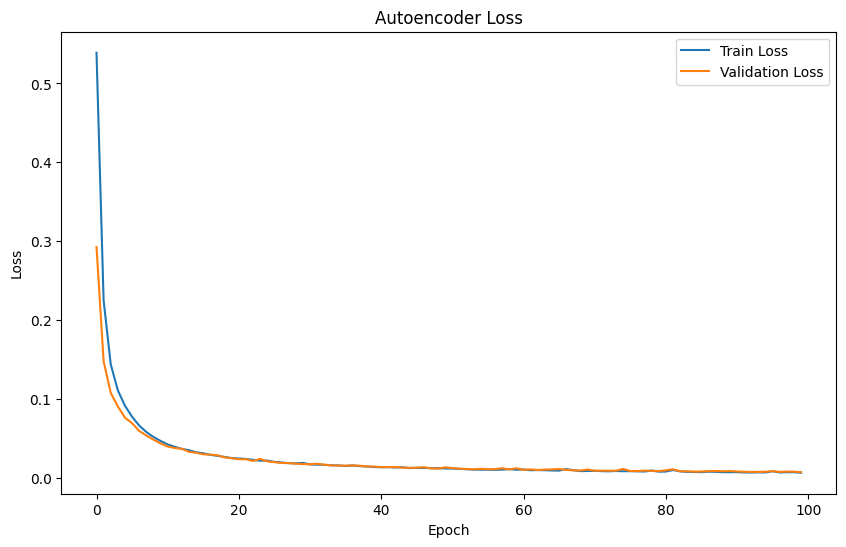

In [32]:
# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [33]:
# Function to compute reconstruction error
def ae_reconstruction_error(model, X):
    reconstructions = model.predict(X, verbose=0)
    mse = np.mean(np.power(X - reconstructions, 2), axis=1)
    return mse

# Compute reconstruction errors for validation set
ae_val_errors = ae_reconstruction_error(autoencoder, X_val)

# Find the best threshold based on validation set
best_ae_thresh = find_best_threshold(y_val, ae_val_errors)
print(f"\nBest Autoencoder Threshold: {best_ae_thresh:.4f}")

# Predict on test set based on reconstruction error
ae_test_errors = ae_reconstruction_error(autoencoder, X_test)
ae_preds_test = (ae_test_errors > best_ae_thresh).astype(int)


Best Autoencoder Threshold: 0.3465
Autoencoder - Precision: 0.9866, Recall: 0.7891, F1: 0.8769, AUC: 0.8931, Accuracy: 0.9535


(np.float64(0.9866342648845686),
 np.float64(0.7891156462585034),
 np.float64(0.8768898488120951),
 np.float64(0.8931395662958324))

## Evaluation

In [34]:
def evaluate(y_true, y_pred, model_name="Model"):
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1v = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = float('nan')  # If only one class is present in y_true
    print(f"{model_name} - Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1v:.4f}, AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")
    return prec, rec, f1v, auc

print("\nTest Set Evaluation:")
evaluate(y_test, iso_preds_test, model_name="Isolation Forest")
evaluate(y_test, lof_preds_test, model_name="LOF")
evaluate(y_test, ae_preds_test, model_name="Autoencoder")



Test Set Evaluation:
Isolation Forest - Precision: 0.9698, Recall: 0.9971, F1: 0.9832, AUC: 0.9944, Accuracy: 0.9929
LOF - Precision: 0.9316, Recall: 0.6220, F1: 0.7459, AUC: 0.8049, Accuracy: 0.9111
Autoencoder - Precision: 0.9866, Recall: 0.7891, F1: 0.8769, AUC: 0.8931, Accuracy: 0.9535


(np.float64(0.9866342648845686),
 np.float64(0.7891156462585034),
 np.float64(0.8768898488120951),
 np.float64(0.8931395662958324))

In [36]:
# Save the model
joblib.dump(iso, 'wifi_iso_model.pkl')

['wifi_iso_model.pkl']